# MMPose预训练模型预测-Python API

同济子豪兄 2023-4-1

## 进入 mmpose 主目录

In [2]:
import os
os.chdir('mmpose')

## 导入工具包

In [3]:
import cv2
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import torch

import mmcv
from mmcv import imread
import mmengine
from mmengine.registry import init_default_scope

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples

from mmdet.apis import inference_detector, init_detector

In [4]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 载入待测图像

In [5]:
img_path = 'data/test/multi-person.jpeg'

In [6]:
# Image.open(img_path)

## 构建目标检测模型

In [7]:
detector = init_detector(
    'demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py',
    'https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth',
    device=device
)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
04/03 13:57:38 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
04/03 13:57:38 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


## 构建人体姿态估计模型

In [8]:
pose_estimator = init_pose_estimator(
    'configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192.py',
    'https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth',
    device=device,
    cfg_options={'model': {'test_cfg': {'output_heatmaps': True}}}
)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth


## 预测-目标检测

In [9]:
init_default_scope(detector.cfg.get('default_scope', 'mmdet'))

04/03 13:57:46 - mmengine - WARNING - The current default scope "mmpose" is not "mmdet", `init_default_scope` will force set the currentdefault scope to "mmdet".


In [10]:
# 获取目标检测预测结果
detect_result = inference_detector(detector, img_path)

In [11]:
detect_result.keys()

['ignored_instances', 'gt_instances', 'pred_instances']

In [12]:
# 预测类别
detect_result.pred_instances.labels

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0, 11,  0, 58,  0,  0, 58,  0,  0,  2,
         0,  0,  2,  0,  0,  0,  0, 24,  2, 58, 26, 26,  0,  0, 58, 26,  0,  0,
        27, 24,  0, 26, 26, 26, 26, 26, 58,  0, 26, 26, 26,  2, 32,  2, 58, 39,
         2,  0, 24, 58, 58, 32, 24, 26,  0,  0,  2, 37,  0, 39,  9, 74,  0,  2,
        58, 24,  0,  0, 26, 29], device='cuda:0')

In [13]:
# 置信度
detect_result.pred_instances.scores

tensor([0.9994, 0.9988, 0.9974, 0.9963, 0.9959, 0.9930, 0.9914, 0.9901, 0.9868,
        0.9824, 0.9631, 0.9272, 0.9079, 0.8950, 0.8793, 0.8581, 0.8248, 0.8189,
        0.7240, 0.7184, 0.7055, 0.6653, 0.6202, 0.6010, 0.6001, 0.5708, 0.5651,
        0.5058, 0.4550, 0.4086, 0.3941, 0.3906, 0.3535, 0.3200, 0.3102, 0.2593,
        0.2291, 0.2223, 0.2156, 0.1888, 0.1865, 0.1845, 0.1792, 0.1771, 0.1715,
        0.1672, 0.1396, 0.1391, 0.1390, 0.1371, 0.1350, 0.1249, 0.1204, 0.1155,
        0.1129, 0.1121, 0.1010, 0.1009, 0.0939, 0.0922, 0.0919, 0.0916, 0.0885,
        0.0822, 0.0807, 0.0724, 0.0697, 0.0686, 0.0675, 0.0630, 0.0627, 0.0624,
        0.0587, 0.0580, 0.0557, 0.0536, 0.0509, 0.0503], device='cuda:0')

In [14]:
# 框坐标：左上角X坐标、左上角Y坐标、右下角X坐标、右下角Y坐标
# detect_result.pred_instances.bboxes

## 置信度阈值过滤，获得最终目标检测预测结果

In [15]:
# 置信度阈值
CONF_THRES = 0.5

In [16]:
pred_instance = detect_result.pred_instances.cpu().numpy()
bboxes = np.concatenate((pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
bboxes = bboxes[np.logical_and(pred_instance.labels == 0, pred_instance.scores > CONF_THRES)]
bboxes = bboxes[nms(bboxes, 0.3)][:, :4]

In [17]:
bboxes

array([[1705.6345   ,   96.277565 , 2114.5242   , 1301.1721   ],
       [1267.5804   ,   94.68924  , 1701.053    , 1316.3138   ],
       [ 720.3783   ,  172.2562   , 1152.6825   , 1267.8347   ],
       [   7.2657757,  238.25836  ,  171.0014   , 1140.8154   ],
       [1063.183    ,  219.23286  , 1348.9962   , 1244.7703   ],
       [ 436.2397   ,  428.5876   ,  586.0957   ,  911.89386  ],
       [ 110.00883  ,  212.14699  ,  324.64886  , 1122.9819   ],
       [2079.3267   ,  478.2376   , 2224.4104   ,  925.2163   ],
       [ 543.71204  ,  406.47882  ,  650.8417   ,  919.4732   ],
       [2363.2961   ,  501.86667  , 2455.2178   ,  857.2747   ],
       [2308.2004   ,  561.4538   , 2372.7483   ,  715.7691   ],
       [1990.6042   ,  485.10385  , 2105.6318   ,  923.45557  ],
       [2255.5461   ,  568.4462   , 2326.8745   ,  702.4359   ],
       [ 830.3824   ,  297.2083   ,  897.0394   ,  349.59433  ],
       [ 704.9901   ,  419.5507   ,  808.7075   ,  989.6197   ],
       [1646.6725   ,  48

## 预测-关键点

In [18]:
# 获取每个 bbox 的关键点预测结果
pose_results = inference_topdown(pose_estimator, img_path, bboxes)

04/03 13:57:56 - mmengine - WARNING - The current default scope "mmdet" is not "mmpose", `init_default_scope` will force set the currentdefault scope to "mmpose".


In [19]:
len(pose_results)

18

In [20]:
# 把多个bbox的pose结果打包到一起
data_samples = merge_data_samples(pose_results)

In [21]:
data_samples.keys()

['pred_fields', '_pred_heatmaps', 'gt_instances', 'pred_instances']

## 预测结果-关键点坐标

In [22]:
# 每个人 17个关键点 坐标
data_samples.pred_instances.keypoints.shape

(18, 17, 2)

In [23]:
# 索引为 0 的人，每个关键点的坐标
data_samples.pred_instances.keypoints[0,:,:]

array([[1915.96261978,  186.8800087 ],
       [1927.72916794,  175.11346054],
       [1892.42952347,  175.11346054],
       [1963.02881241,  198.64655685],
       [1857.129879  ,  186.8800087 ],
       [2010.09500504,  316.31203842],
       [1810.06368637,  328.07858658],
       [2092.46084213,  492.81026077],
       [1786.53059006,  445.74406815],
       [1986.56190872,  410.44442368],
       [1762.99749374,  504.57680893],
       [1963.02881241,  657.54193497],
       [1821.83023453,  645.77538681],
       [1939.49571609,  939.93909073],
       [1821.83023453,  904.63944626],
       [1927.72916794, 1116.43731308],
       [1857.129879  , 1187.03660202]])

## 预测结果-关键点热力图

In [24]:
# 每一类关键点的预测热力图
data_samples.pred_fields.heatmaps.shape

(17, 1418, 2520)

In [25]:
idx_point = 13
heatmap = data_samples.pred_fields.heatmaps[idx_point,:,:]

In [26]:
heatmap.shape

(1418, 2520)

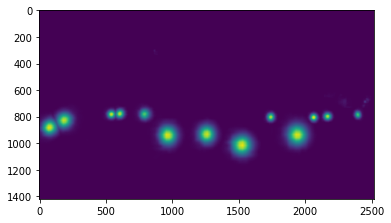

In [27]:
# 索引为 idx 的关键点，在全图上的预测热力图
plt.imshow(heatmap)
plt.show()

## 可视化配置

In [28]:
# 半径
pose_estimator.cfg.visualizer.radius = 3
# 线宽
pose_estimator.cfg.visualizer.line_width = 1
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
# 元数据
visualizer.set_dataset_meta(pose_estimator.dataset_meta)

04/03 13:58:22 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


In [29]:
# 元数据
# pose_estimator.dataset_meta

## 展示可视化效果

In [30]:
img = mmcv.imread(img_path)
img = mmcv.imconvert(img, 'bgr', 'rgb')

img_output = visualizer.add_datasample(
            'result',
            img,
            data_sample=data_samples,
            draw_gt=False,
            draw_heatmap=True,
            draw_bbox=True,
            show=False,
            wait_time=0,
            out_file='outputs/B2.jpg',
            kpt_score_thr=0.3)

In [31]:
img_output.shape

(2836, 2520, 3)

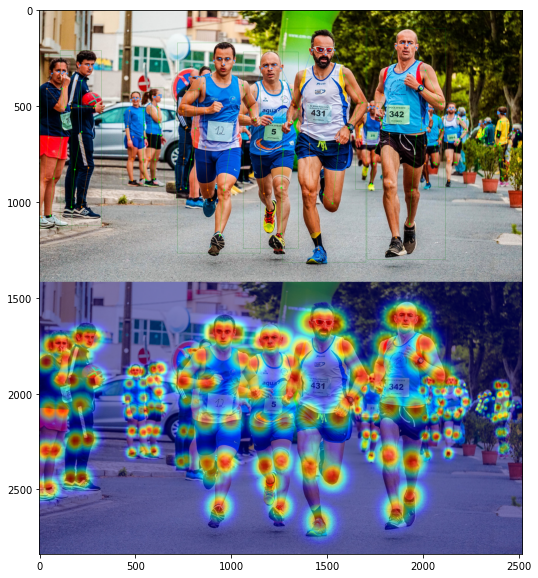

In [32]:
plt.figure(figsize=(10,10))
plt.imshow(img_output)
plt.show()